# **Weather Data Analysis for Irish Locations**

## **1. Introduction**

This notebook analyses Irish weather data to examine wind speed trends and evaluate the potential for wind farm development. By the end, it aims to determine which of the five analysed locations is most suitable for wind energy production.

In [459]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from itables import show
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

[Reference: Pandas DataFrames as interactive HTML DataTables](https://marc-wouts.medium.com/pandas-dataframes-as-interactive-html-datatables-9737c7266abf)<br/>

---

## **2. Loading Weather Data by Location**

This section loads weather data from Met Éireann for five Irish locations—Cork, Dublin, Knock, Malin Head, and Mullingar—and adds location identifiers for analysis.

In [460]:
# Function to load a CSV file and add a 'Location' column
def load_data(file_path, location):
    data = pd.read_csv(file_path, skiprows=19) 
    data['Location'] = location 
    return data

# File paths for weather data CSVs
file_paths = [
    'data/cork_airport.csv',
    'data/dublin_airport.csv',
    'data/knock_airport.csv',
    'data/malin_head.csv',
    'data/mullingar.csv']

# Corresponding location names
locations = ['Cork', 'Dublin', 'Knock', 'Malin Head', 'Mullingar']

# Load all datasets and store them in a list
weather_data_frames = [load_data(file_path, location) for file_path, location in zip(file_paths, locations)]

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>
[Reference: Met Eireann Historical Data](https://www.met.ie/climate/available-data/historical-data)<br/>

---


## **3. Consolidating Data**

Data from all locations is combined into a single dataset. The consolidated data is stored in an SQLite database for efficient querying.

#### **Column Descriptions:**
- **year**: Year  
- **month**: Month  
- **rain**: Precipitation Amount (mm)  
- **meant**: Mean Air Temperature (°C)  
- **maxtp**: Maximum Air Temperature (°C)  
- **mintp**: Minimum Air Temperature (°C)  
- **mnmax**: Mean Maximum Temperature (°C)  
- **mnmin**: Mean Minimum Temperature (°C)  
- **gmin**: Grass Minimum Temperature (°C)  
- **wdsp**: Mean Wind Speed (knot)  
- **mxgt**: Highest Gust (knot)  
- **sun**: Sunshine Duration (hours)  


In [461]:
# Concatenate all DataFrames
all_data = pd.concat(weather_data_frames, ignore_index=True)

# Show concatenated data
show(all_data)

[Reference: pandas.concat() function in Python](https://www.geeksforgeeks.org/pandas-concat-function-in-python/)<br/>

In [462]:
# Save the consolidated data to an SQLite database
conn = sqlite3.connect('data/weather_data.db')
all_data.to_sql('consolidated_weather', conn, if_exists='replace', index=False)

# Confirm the data was stored correctly
print("Preview of consolidated data in SQLite:")
print(pd.read_sql_query("SELECT * FROM consolidated_weather LIMIT 3", conn))

Preview of consolidated data in SQLite:
   year  month  meant maxtp mintp  mnmax  mnmin rain  gmin  wdsp maxgt sun  \
0  1962      1    5.5  11.6  -3.8    8.2    2.7       -6.3  12.8    70       
1  1962      2    5.3  12.3  -2.7    7.9    2.7       -4.4  13.6    57       
2  1962      3    4.2  12.2  -5.4    7.5    0.9       -7.2  10.3    63       

  Location  
0     Cork  
1     Cork  
2     Cork  


[Reference: How to write Pandas dataframe to sqlite with Index](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index)<br/>
[Reference: Accessing SQLite Databases Using Python and Pandas](https://datacarpentry.github.io/python-ecology-lesson/instructor/09-working-with-sql.html)<br/>
[Reference: Pandas Read SQL Query or Table with Examples](https://sparkbyexamples.com/pandas/pandas-read-sql-query-or-table/)<br/>
[Reference: MySQL LIMIT Clause](https://www.w3schools.com/mysql/mysql_limit.asp)<br/>

In [463]:
# Query to filter data for year >= 1997 and month >= 1
query = """
SELECT * 
FROM consolidated_weather
WHERE year >= 1997 AND month >= 1
"""
analysis_weather_records = pd.read_sql_query(query, conn)

# Show filtered data
show(analysis_weather_records)

[Reference: The SQL WHERE Clause](https://www.w3schools.com/sql/sql_where.asp)<br/>
[Reference: MySQL AND, OR and NOT Operators](https://www.w3schools.com/mysql/mysql_and_or.asp)<br/>

----

## **4. Handling Missing Values**

The dataset is cleaned by replacing blank entries with NaN. Missing values are analysed by location to ensure data quality, and the cleaned data is saved to a SQLite database for further use.

In [464]:
# Replace blank fields and '-' with NaN in the filtered data
analysis_weather_records.replace([r'^\s*$'], np.nan, regex=True, inplace=True)

# Count and display missing values grouped by location
missing_values = analysis_weather_records.isnull().groupby(analysis_weather_records['Location']).sum()
show(missing_values)


[Reference: Replace values in Pandas dataframe using regex](https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/)<br/>
[Reference: Pandas: How to Replace Zero with NaN](https://www.statology.org/pandas-replace-0-with-nan/)<br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>
[Reference: pd.NA vs np.nan for pandas](https://stackoverflow.com/questions/60115806/pd-na-vs-np-nan-for-pandas)<br/>
[Reference: A Guide to R Regular Expressions](https://www.datacamp.com/tutorial/regex-r-regular-expressions-guide) <br/>


#### **Overview of Missing Data:**  
- **Data Gaps:**  
  - `sun`: Missing from **Mullingar** (Since 2007), **Malin Head** (Since 2011), **Knock** (Since 2020).  

- **Location Specific Gaps:**  
  - **Dublin**: 1 `gmin` value missing.  
  - **Mullingar**: 1 `gmin`, 2 `wsdp`, and 4 `maxgt` values missing.  
  - **Malin Head**: 1 `wdsp` value missing.  
  - **Knock**: 3 `maxgt` values missing.  

- **Exclusions from Analysis**:
  - The `sun` and `gmin` columns will be excluded from the analysis as they are not relevant to the goals of this project.
  - Three missing `wdsp` values will be dropped, as it is negligible in the overall dataset.

In [465]:
# Display the data types of all columns to verify they are correctly formatted for analysis
print(analysis_weather_records.dtypes)

year          int64
month         int64
meant       float64
maxtp        object
mintp        object
mnmax       float64
mnmin       float64
rain         object
gmin         object
wdsp         object
maxgt        object
sun          object
Location     object
dtype: object


In [466]:
# Convert selected columns to numeric data types, coercing invalid entries to NaN for cleaning
columns_to_convert = ['maxtp', 'mintp', 'rain', 'gmin', 'wdsp', 'maxgt', 'sun']
for col in columns_to_convert:
    analysis_weather_records[col] = pd.to_numeric(analysis_weather_records[col], errors='coerce')

[Reference: pandas: to_numeric for multiple columns](https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns)<br/>

In [467]:
# Check the data types of all columns after conversion to ensure they are now correctly formatted
print(analysis_weather_records.dtypes)

year          int64
month         int64
meant       float64
maxtp       float64
mintp       float64
mnmax       float64
mnmin       float64
rain        float64
gmin        float64
wdsp        float64
maxgt       float64
sun         float64
Location     object
dtype: object


In [468]:
# Remove rows where 'wdsp' has NaN values and reset the index
cleaned_weather_records = analysis_weather_records.dropna(subset=['wdsp']).reset_index(drop=True)

[Reference: Pandas: How to Use dropna() with Specific Columns](https://www.statology.org/pandas-dropna-specific-column/)<br/>


In [469]:
# Save the cleaned dataset to a new SQLite table for reuse
conn = sqlite3.connect('data/weather_data.db')
cleaned_weather_records.to_sql('cleaned_weather', conn, if_exists='replace', index=False)
print("\nCleaned dataset saved as 'cleaned_weather' in SQLite database.")


Cleaned dataset saved as 'cleaned_weather' in SQLite database.


[Reference: How to write Pandas dataframe to sqlite with Index](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index)<br/>

---

## **5. Monthly Wind Speed Over Time by Location**


This section analyses monthly mean wind speeds for each location, visualised through line plots, to assess consistency and suitability for wind farm development.

#### **Line Plot with Markers Showing the Monthly Mean Wind Speed for Each Location**

In [470]:
# Extract relevant columns and create a copy to avoid modifying the original DataFrame
monthly_wind_speed_data = cleaned_weather_records[['Location', 'year', 'month', 'wdsp']].copy()

# Add a 'date' column and convert to datetime
monthly_wind_speed_data['date'] = pd.to_datetime(
    monthly_wind_speed_data[['year', 'month']].assign(day=1))

# Create subplots for each location
locations = monthly_wind_speed_data['Location'].unique()
fig = make_subplots(
    rows=len(locations), cols=1, shared_xaxes=True,
    subplot_titles=[f"Average Wind Speed - {loc}" for loc in locations])

# Plot wind speed trends for each location
for i, location in enumerate(locations):
    fig.add_trace(
        go.Scatter(
            x=monthly_wind_speed_data[monthly_wind_speed_data['Location'] == location]['date'],
            y=monthly_wind_speed_data[monthly_wind_speed_data['Location'] == location]['wdsp'],
            mode='lines+markers',
            name=location),
        row=i + 1, col=1)

# Configure figure layout and shared axis settings
fig.update_layout(
    height=300 * len(locations),
    template="plotly_white",
    showlegend=False)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Average Wind Speed (knots)")

# Show plot
fig.show()




[Reference:Plotly- Subplots in Python](https://plotly.com/python/subplots/)<br/>
[Reference:Plotly- Scatter Plots in Python ](https://plotly.com/python/line-and-scatter/)<br/>
[Reference:Plotly- Python Figure Reference: layout ](https://plotly.com/python/reference/layout/)<br/>
[Reference:Plotly- Python Figure Reference: layout.xaxis ](https://plotly.com/python/reference/layout/xaxis/)<br/>
[Reference:Python Figure Reference: layout.yaxis ](https://plotly.com/python/reference/layout/yaxis/#:~:text=Python%20Figure%20Reference%3A%20layout.,yaxis&text=Type%3A%20dict%20containing%20one%20or%20more%20of%20the%20keys%20listed%20below.&text=If%20set%20to%20an%20opposite,the%20corresponding%20opposite%2Dletter%20axis.)<br/>
[Reference: Pandas DataFrame copy() Method](https://www.w3schools.com/python/pandas/ref_df_copy.asp)<br/>
[Reference: Pandas DataFrame assign() Method | Create new Columns in DataFrame](https://www.geeksforgeeks.org/pandas-dataframe-assign/)<br/>
[Reference: How to Specify Format in pandas.to_datetime](https://www.statology.org/pandas-to-datetime-format/) <br/>
[Reference: The Basics of the Python Enumerate() Function](https://blog.hubspot.com/website/python-enumerate)<br/>

#### **Monthly Wind Speed Over Time by Location Analysis**

 **Cork**:  
   - **Range**: 6.1–15 knots (Highest: Feb 1997).  
   - Generally steady with winter spikes.  

 **Dublin**:  
   - **Range**: 6.5–16.4 knots (Highest: Feb 1997).  
   - Slight decline since 2018, with winter spikes.  

 **Knock**:  
   - **Range**: 6.1–15 knots (Highest: Feb 1997).  
   - Generally steady with winter spikes.  

 **Malin Head**:  
   - **Range**: 7.8–22.9 knots (Highest: Feb 1997).  
   - Largest seasonal variance, frequent winter spikes.  

 **Mullingar**:  
   - **Range**: 3.6–11.2 knots (Highest: Feb 1997).  
   - Generally steady with winter spikes.  
 
All locations recorded their highest wind speed in February 1997, highlighting a significant weather event. **Malin Head's** strong, variable winds could make it ideal for wind farms, while **Cork**, **Dublin**, **Knock**, and **Mullingar** may offer steadier but moderate wind energy potential.

----

## **6. Seasonal Wind Speed by Location**


This section examines average wind speeds by season for each location, highlighting seasonal patterns and their impact on wind energy potential. Insights are visualised using bar plots and a sunburst chart.

In [471]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add a 'season' column to the DataFrame
monthly_wind_speed_data['Season'] = monthly_wind_speed_data['month'].apply(get_season)

# Group by Location and Season, and calculate the mean wind speed
seasonal_wind_speed_summary = (
    monthly_wind_speed_data
    .groupby(['Location', 'Season'])['wdsp']
    .mean()
    .reset_index()
    .sort_values(by=['Location', 'Season']))

# Rename the columns for clarity
seasonal_wind_speed_summary.columns = ['Location', 'Season', 'Average Wind Speed']

# Show the Summary
show(seasonal_wind_speed_summary)

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>
[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>

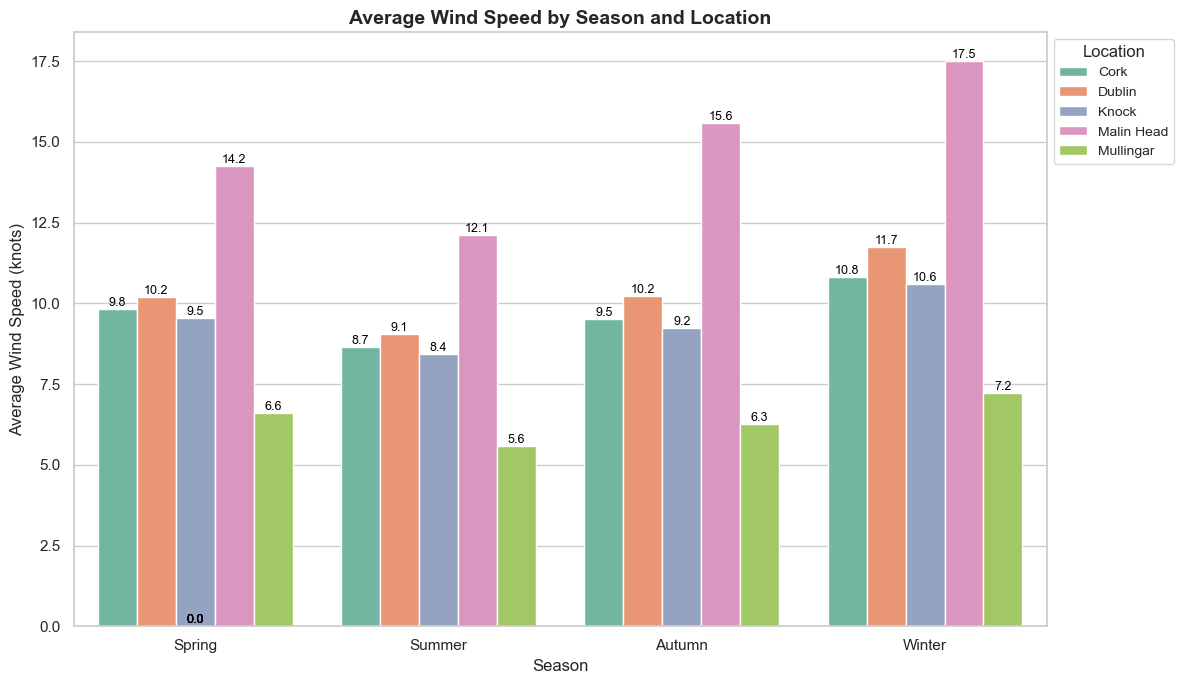

In [472]:
# Order seasons 
seasonal_wind_speed_summary['Season'] = pd.Categorical(
    seasonal_wind_speed_summary['Season'],
    categories=['Spring', 'Summer', 'Autumn', 'Winter'],
    ordered=True)

# Select the correct number of colours
num_locations = seasonal_wind_speed_summary['Location'].nunique()
palette = sns.color_palette("Set2", n_colors=num_locations)  # Use only required colours

# Create bar plot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=seasonal_wind_speed_summary,
    x='Season',
    y='Average Wind Speed',
    hue='Location',
    palette=palette)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color='black')

# Labels and legend
plt.title("Average Wind Speed by Season and Location", fontsize=14, weight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Wind Speed (knots)", fontsize=12)
plt.legend(title="Location", loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Show chart
plt.tight_layout()
plt.show()

[Reference: Grouped Barplot using Seaborn](https://python-graph-gallery.com/grouped-barplot/)<br/>
[Reference: Annotate bars with values on Pandas bar plots](https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots)<br/>
[Reference: How To Annotate Bars in Barplot with Matplotlib in Python?](https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)<br/>

In [473]:
# Suppress the FutureWarning that does not impact functionality
warnings.filterwarnings("ignore", message="The default of observed=False is deprecated")

# Prepare the data
sunburst_data = seasonal_wind_speed_summary

# Create the sunburst chart
fig = px.sunburst(
    sunburst_data,
    path=['Location', 'Season'],
    values='Average Wind Speed',
    color='Average Wind Speed',
    color_continuous_scale='Blues',
    title="Seasonal Wind Speed Distribution by Location")

# Customise the layout 
fig.update_layout(
    title_font_size=20,
    title_x=0.5, 
    margin=dict(t=40, l=20, r=20, b=20),  # Adjust margins
    coloraxis_colorbar=dict(
        title="Avg Wind Speed (knots)",
        thickness=15,
        len=0.5,
        orientation="v"))

# Show the chart
fig.show()

[Reference: BUG: Un-actionable FutureWarning in DataFrame.value_counts with categorical column(s)](https://github.com/pandas-dev/pandas/issues/54775)<br/>
[Reference: Plotly- Sunburst Charts in Python](https://plotly.com/python/sunburst-charts/)<br/>
[Reference: Plotly- plotly.express.sunburst](https://plotly.com/python-api-reference/generated/plotly.express.sunburst.html?)<br/>
[Reference:Plotly- Python Figure Reference: layout ](https://plotly.com/python/reference/layout/)<br/>
[Reference: Plotly- Excessive margins in graphs (how to remove?)](https://community.plotly.com/t/excessive-margins-in-graphs-how-to-remove/49094)<br/>

#### **Seasonal Wind Speed by Location Analysis**
Winter provides the highest wind energy potential, while summer has the lowest. Coastal locations like **Malin Head** and **Dublin** overall perform best, highlighting the importance of site selection. Seasonal variability may highlight the need for strategies to manage lower summer output.

---

## **7. Yearly Wind Speed Summary by Location and Wind Farm Location Suitability**


This section analyses yearly wind speed trends for each location, calculating mean, median, and variance to assess consistency and strength for wind farm suitability.

In [474]:
# Group by Location and Year, and calculate summary statistics
yearly_wind_speed_summary = (
    monthly_wind_speed_data
    .groupby(['Location', 'year'])['wdsp']
    .agg(['mean', 'median', 'var'])
    .reset_index())

# Rename the columns for clarity
yearly_wind_speed_summary.columns = ['Location', 'Year', 'Mean Wind Speed', 'Median Wind Speed', 'Variance']


[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Pandas Series agg() Method](https://www.geeksforgeeks.org/python-pandas-series-agg/)
<br/>

In [475]:
# Create a scatter matrix 
fig = px.scatter_matrix(
    yearly_wind_speed_summary,
    dimensions=["Mean Wind Speed", "Median Wind Speed", "Variance"],  # Metrics to compare
    color="Location",  # Differentiate points by location
    title="Yearly Wind Speed Analysis",  # Add a  title
    labels={"Mean Wind Speed": "Mean", "Median Wind Speed": "Median", "Variance": "Variance"},  # Label axes
    hover_data=["Year"]  # Display year on hover
)

# Customise layout
fig.update_layout(
    title_font_size=18, 
    title_x=0.5,  
    height=800, 
    width=800, 
    font=dict(size=12))

# Display the plot
fig.show()

[Reference:Plotly- Scatterplot Matrix in Python](https://plotly.com/python/splom/) <br/>
[Reference: Plotly- Hover Text and Formatting in Python](https://plotly.com/python/hover-text-and-formatting/#:~:text=Customizing%20Hover%20text%20with%20Plotly%20Express,-Plotly%20Express%20functions&text=The%20hover_data%20argument%20accepts%20a,bold%20as%20the%20tooltip%20title.)
<br/>
[Reference:Plotly- Python Figure Reference: layout ](https://plotly.com/python/reference/layout/)<br/>

Wind turbines start operating at **Beaufort Force 3**, reach maximum power at **Force 5**, and shut down at Storm **Force 10** to prevent damage
<br/><br/>
[Source: Irish Wind Energy Association](http://www.iwea.ie/technicalfaqs#:~:text=Turbines%20reach%20maximum%20power%20output,prevent%20excessive%20wear%20and%20tear.)
<br/>
| Beaufort Rating | Wind Speed (Knots) |
|-----------------|--------------------|
| 0               | < 1                |
| 1               | 1–3                |
| 2               | 4–6                |
| 3               | 7–10               |
| 4               | 11–16              |
| 5               | 17–21              |


[Source: Met Eireann](https://www.met.ie/cms/assets/uploads/2022/09/Beaufort-scale-for-land.png)
<br/>

In [476]:
# Group by Location and calculate summary statistics
location_summary = yearly_wind_speed_summary.groupby('Location').agg(
    Mean_Wind_Speed_Min=('Mean Wind Speed', 'min'),
    Mean_Wind_Speed_Max=('Mean Wind Speed', 'max'),
    Variance_Avg=('Variance', 'mean')).reset_index()

# Function to classify wind speed suitability for turbines based on max, min, and variance
def classify_wind_speed(row):
    max_wind_knots = row['Mean_Wind_Speed_Max']
    min_wind_knots = row['Mean_Wind_Speed_Min']
    wind_variance = row['Variance_Avg']
    
    # Strong winds: Beaufort 5 and above (17+ knots)
    if max_wind_knots >= 17:
        if wind_variance < 3:
            return "Strong and stable winds, turbines reach maximum power."
        else:
            return "Strong but variable winds, turbines reach maximum power."
    
    # Moderate winds: Beaufort 4 (11–16 knots)
    elif max_wind_knots >= 11:
        if min_wind_knots >= 7 and wind_variance < 3:
            return "Moderate and stable winds, turbines operate efficiently."
        else:
            return "Moderate but variable winds, suitable for energy generation."
    
    # Gentle winds: Beaufort 3 (7–10 knots)
    elif max_wind_knots >= 7:
        return "Gentle winds, turbines are operational but efficiency is limited."
    
    # Low winds: Below Beaufort 3 (< 7 knots)
    else:
        return "Low winds, turbines are not operational."

# Add wind speed classification to the new 'Analysis' column on the DataFrame
location_summary['Analysis'] = location_summary.apply(classify_wind_speed, axis=1)

# Display the summary
show(location_summary)

[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>
[Reference: Pandas Series agg() Method](https://www.geeksforgeeks.org/python-pandas-series-agg/)
<br/>
[Reference: Pandas Apply: 12 Ways to Apply a Function to Each Row in a DataFrame](https://www.ml4devs.com/articles/pandas-dataframe-apply-function-iterate-over-rows/)
<br/>
[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>

#### **Yearly Average Wind Speed Analysis**

**Malin Head** offers the strongest winds and highest variability, making it ideal for wind energy. **Dublin** shows high potential with some variability, while **Cork** and **Knock** provide steady but moderate winds. **Mullingar's** low wind speeds make it less suitable for wind farms. As observed in Section 6 Coastal locations clearly outperform inland areas.

---

## **8.Predicting Future Wind Trends**

This section forecasts wind speeds for all locations, eventually focusing on Malin Head and Dublin—the top sites for wind energy potential—using linear regression and SARIMAX models to assess their long-term suitability for wind farms.

#### **Linear Regression**

Linear regression models the relationship between time and wind speed, making it useful for an initial assessment of wind patterns.

In [477]:
# Create a 'date' column by combining 'year' and 'month', setting the day to 1
monthly_wind_speed_data['date'] = pd.to_datetime(monthly_wind_speed_data[['year', 'month']].assign(day=1))

# Convert 'date' to a numeric format for linear regression model
monthly_wind_speed_data['date_numeric'] = monthly_wind_speed_data['date'].map(pd.Timestamp.toordinal)

# Get unique locations from the dataset
locations = monthly_wind_speed_data['Location'].unique()

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>
[Reference: Python: Linear regression from Pandas df - ordinal dates conversion](https://stackoverflow.com/questions/66720622/python-linear-regression-from-pandas-df-ordinal-dates-conversion)<br/>

In [478]:
# Loop through each location to perform wind speed predictions:
for location in locations:
    # Filter the dataset to include only data for the current location
    location_data = monthly_wind_speed_data[monthly_wind_speed_data['Location'] == location]

    # Define features (date) and target (wind speed)
    X = location_data[['date_numeric']]
    y = location_data['wdsp']

    # Split the data into training (80%) and testing (20%)
    split_date = location_data['date'].quantile(0.8)
    train_data = location_data[location_data['date'] <= split_date]
    test_data = location_data[location_data['date'] > split_date]
    
    # Extract features (dates) and target (wind speed) for training and testing
    X_train, y_train = train_data[['date_numeric']], train_data['wdsp']
    X_test, y_test = test_data[['date_numeric']], test_data['wdsp']

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Location: {location} | Mean Absolute Error: {mae}")

Location: Cork | Mean Absolute Error: 1.10809464181946
Location: Dublin | Mean Absolute Error: 2.048103851412383
Location: Knock | Mean Absolute Error: 1.0284103845237575
Location: Malin Head | Mean Absolute Error: 2.2712742725512363
Location: Mullingar | Mean Absolute Error: 0.7995176089631472


[Reference: Python linear regression predict by date](https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date)<br/>
[Reference: Linear Regression in Python](https://realpython.com/linear-regression-in-python/)<br/>
[Reference: Splitting data using time-based splitting in test and train datasets](https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets)<br/>
[Reference: Split Your Dataset With scikit-learn's train_test_split()](https://realpython.com/train-test-split-python-data/)<br/>
[Reference: Split dataframe into two on the basis of date](https://stackoverflow.com/questions/37532098/split-dataframe-into-two-on-the-basis-of-date)<br/>
[Reference: Pandas date_range to generate monthly data at beginning of the month](https://stackoverflow.com/questions/34915828/pandas-date-range-to-generate-monthly-data-at-beginning-of-the-month)<br/>
[Reference: Pandas quantile()](https://www.programiz.com/python-programming/pandas/methods/quantile#:~:text=Add%20two%20numbers-,Pandas%20quantile.)<br/>
[Reference: How to Calculate Mean Absolute Error in Python](https://www.statology.org/mean-absolute-error-python/)<br/>


 #### **Linear Regression Analysis**  

**MAE** measures the average error between predicted and actual values, offering a simple accuracy metric. However, high variability in **Dublin** and **Malin Head**, driven by seasonal spikes, has affected linear regression predictions.  

To improve accuracy, time-based splits and numeric date features were applied. However, a model better suited to handling outliers and variability is needed.  

Given their potential, **Dublin** and **Malin Head** will be the focus for developing a more accurate wind speed prediction model.  

[Reference: Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)<br/>
[Reference: Mastering Mean Absolute Error: A Beginner's Guide to Evaluating Regression Models)](https://the-pi-guy.com/blog/mastering_mean_absolute_error_a_beginners_guide_to_evaluating_regression_models/)<br/>

#### **Time Series Forecasting with SAIRMAX**

SARIMAX handles seasonality and variability in time series data, making it ideal for predicting wind speeds at **Malin Head** and **Dublin**, as it captures trends and periodic fluctuations effectively.







In [479]:
# Load the cleaned_weather table
query_cleaned = "SELECT * FROM cleaned_weather;"
cleaned_weather = pd.read_sql_query(query_cleaned, conn)

Location: Dublin | Mean Absolute Error (MAE): 0.9971667869551819


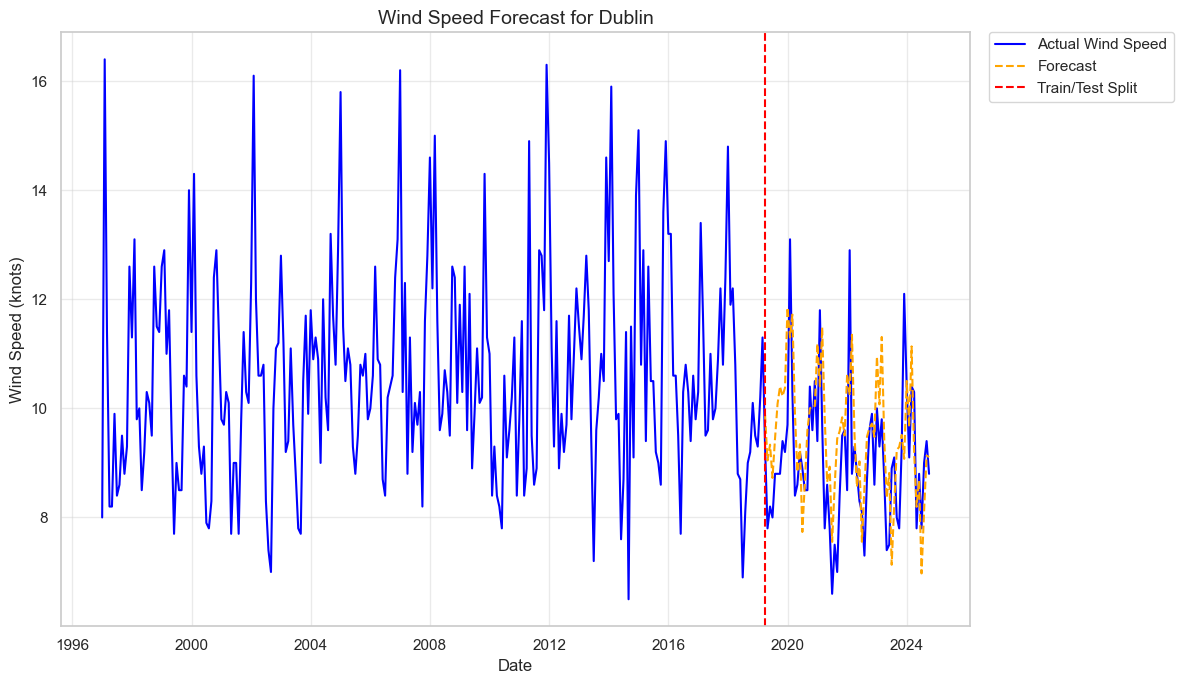

Location: Malin Head | Mean Absolute Error (MAE): 1.4306284358235362


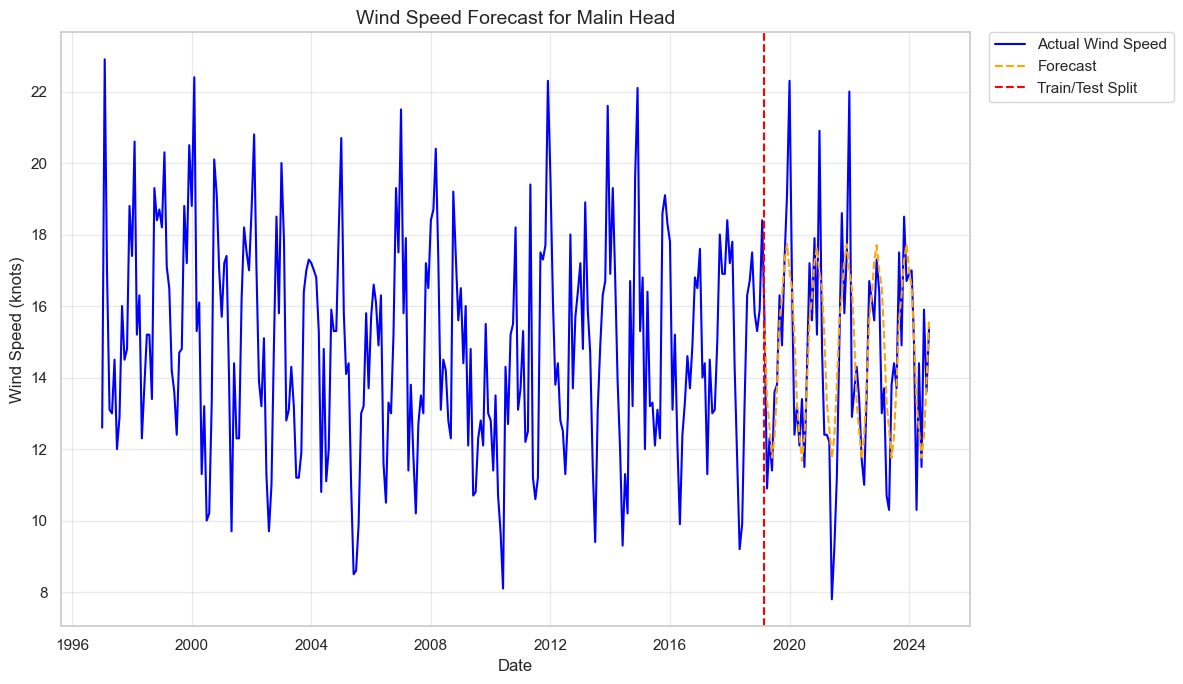

In [480]:
# SARIMAX parameters for each location
locations = {
    "Dublin": {
        "arima_order": (1, 1, 1),       # Non-seasonal ARIMA
        "seasonal_order": (2, 2, 2, 12) # Seasonal ARIMA 
    },
    "Malin Head": {
        "arima_order": (1, 1, 1),       # Non-seasonal ARIMA
        "seasonal_order": (2, 1, 2, 12) # Seasonal ARIMA    
    }}

# Loop through each location to forecast wind speeds using SARIMAX:
for location, params in locations.items():
    # Filter and select data for the current location.
    location_data = cleaned_weather[cleaned_weather['Location'] == location][['year', 'month', 'wdsp']].copy()

    # Create a datetime index using 'year' and 'month'
    location_data['date'] = pd.to_datetime(location_data[['year', 'month']].assign(day=1))
    location_data.set_index('date', inplace=True)

    # Ensure the index has a consistent frequency (month start)
    location_data.index = pd.date_range(start=location_data.index[0], periods=len(location_data), freq='MS')

    # Split the data into training (80%) and testing (20%)
    split_date = location_data.index[int(len(location_data) * 0.8)]
    train_data = location_data[location_data.index < split_date]
    test_data = location_data[location_data.index >= split_date].copy()  # Create a copy to avoid 'SettingWithCopyWarning'

    # Fit a SARIMAX model to the training data
    seasonal_model = SARIMAX(
        train_data['wdsp'], 
        order=params['arima_order'],  # Use individual ARIMA order for the location
        seasonal_order=params['seasonal_order'],  # Use individual seasonal order for the location
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    seasonal_fit = seasonal_model.fit(disp=False)  # Suppress long output

    # Generate forecasts for the test set
    test_data['Forecast'] = seasonal_fit.forecast(steps=len(test_data))

    # Calculate the Mean Absolute Error
    mae = mean_absolute_error(test_data['wdsp'], test_data['Forecast'])

    # Print the results
    print(f"Location: {location} | Mean Absolute Error (MAE): {mae}")

    # Plot the results 
    plt.figure(figsize=(12, 7))
    plt.plot(location_data.index, location_data['wdsp'], label='Actual Wind Speed', color='blue', linewidth=1.5)
    plt.plot(test_data.index, test_data['Forecast'], label='Forecast', color='orange', linestyle='--', linewidth=1.5)
    plt.axvline(x=split_date, color='red', linestyle='--', label='Train/Test Split')
    plt.title(f"Wind Speed Forecast for {location}", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Wind Speed (knots)', fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()


[Reference: Complete Guide To SARIMAX in Python](https://www.geeksforgeeks.org/complete-guide-to-sarimax-in-python/)<br/>
[Reference: Seasonality and SARIMAX](https://www.kaggle.com/code/nholloway/seasonality-and-sarimax)<br>
[Reference: Forecasting Time Series Data with SARIMAX: A Step-by-Step Guide](https://medium.com/pythonforall/forecasting-time-series-data-with-sarimax-a-step-by-step-guide-701bffc990dd)<br/>
[Reference: Step-by-Step Guide to Time Series Forecasting with SARIMA Models](https://mlpills.dev/time-series/how-to-train-a-sarima-model-step-by-step/)<br/>
[Reference: Three techniques to improve SARIMAX model for time series forecasting](https://medium.com/@poudel.birat25/three-techniques-to-improve-sarimax-model-for-time-series-forecasting-5d48db984fbe/)<br/>
[Reference: Forecasting in statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html)<br/>
[Reference: Splitting data using time-based splitting in test and train datasets](https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets)<br/>
[Reference: How to Create an Index for Python Pandas DataFrame: A Guide](https://saturncloud.io/blog/how-to-create-an-index-for-python-pandas-dataframe-a-comprehensive-guide/)<br/>
[Reference: Pandas date_range to generate monthly data at beginning of the month](https://stackoverflow.com/questions/34915828/pandas-date-range-to-generate-monthly-data-at-beginning-of-the-month)<br/>
[Reference: How to Calculate Mean Absolute Error in Python](https://www.statology.org/mean-absolute-error-python/)<br/>


#### **SARIMAX Train/Test Analysis**

Different SARIMAX parameters were tested, showing that **Dublin** and **Malin Head** required unique settings for optimal results. **Dublin** achieved an MAE of 0.997, indicating high accuracy, while **Malin Head's MAE** of 1.43 reflects its variability but remains reliable. This model will now forecast wind speeds for the next 10 years to support wind farm planning.

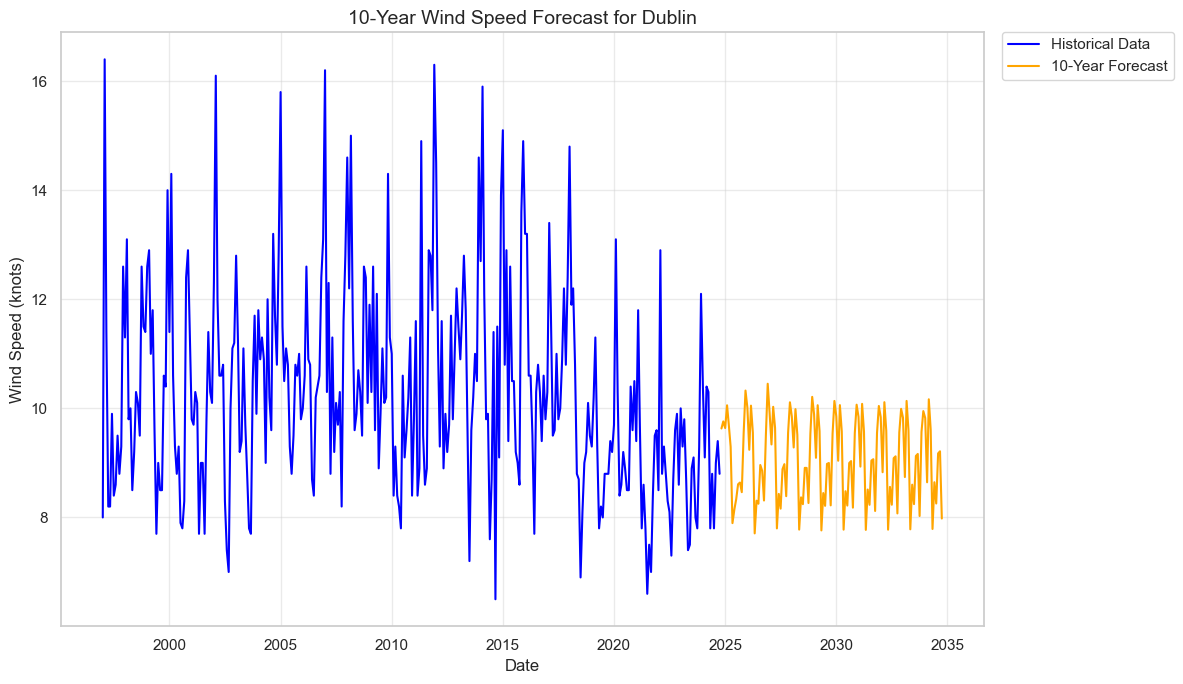

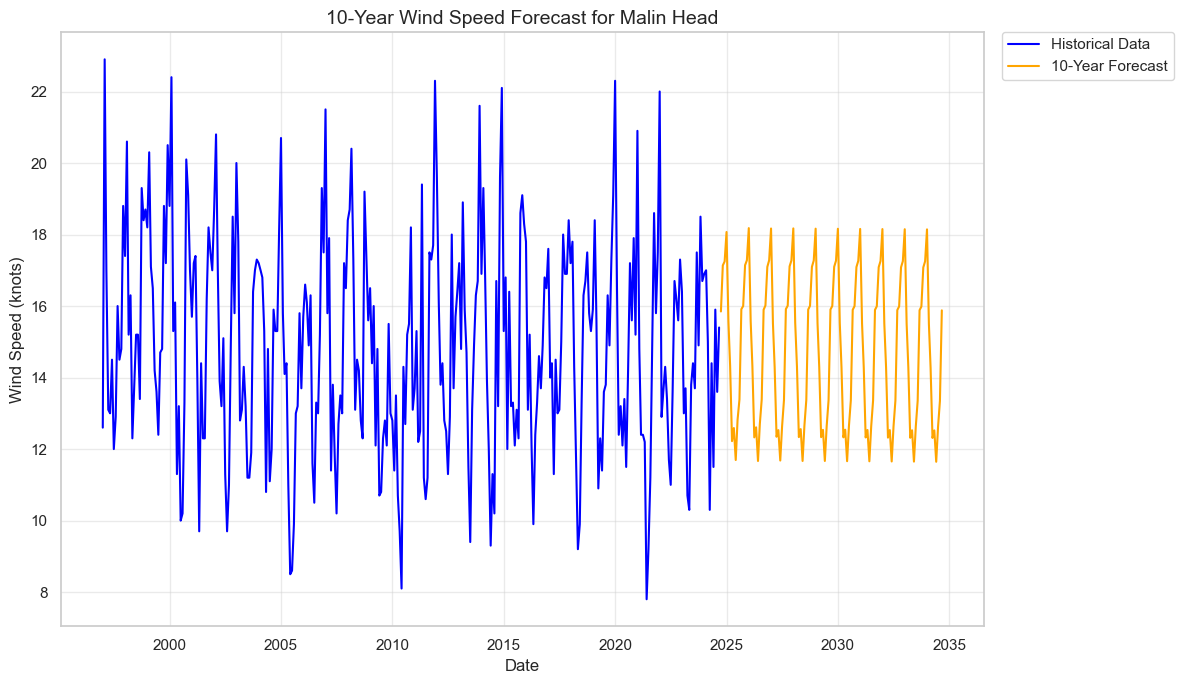

In [481]:
# Forecast 10 years of monthly data
forecast_years = 10
forecast_steps = forecast_years * 12

# SARIMA parameters for each location
locations = {
    "Dublin": {
        "arima_order": (1, 1, 1),        # Non-seasonal ARIMA
        "seasonal_order": (2, 2, 2, 12)  # Seasonal ARIMA
    },
    "Malin Head": {
        "arima_order": (1, 1, 1),        # Non-seasonal ARIMA
        "seasonal_order": (2, 1, 2, 12)  # Seasonal ARIMA
    }
}

# Loop through each location to forecast wind speeds using SARIMAX:
for location, params in locations.items():
    # Filter and select data for the current location.
    location_data = cleaned_weather[cleaned_weather['Location'] == location][['year', 'month', 'wdsp']].copy()

    # Create a datetime index using 'year' and 'month'
    location_data['date'] = pd.to_datetime(location_data[['year', 'month']].assign(day=1))
    location_data.set_index('date', inplace=True)

    # Ensure the index has a consistent frequency (month start)
    location_data.index = pd.date_range(start=location_data.index[0], periods=len(location_data), freq='MS')

    # Fit a SARIMAX model to the entire dataset
    seasonal_model = SARIMAX(
        location_data['wdsp'], 
        order=params['arima_order'],         # Use individual ARIMA order for the location
        seasonal_order=params['seasonal_order'],  # Use individual seasonal order for the location
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    seasonal_fit = seasonal_model.fit(disp=False)  # Suppress long output

    # Generate forecasts for the next 10 years
    forecast_values = seasonal_fit.forecast(steps=forecast_steps)

    # Generate the index for the forecasted dates
    forecast_index = pd.date_range(
        start=location_data.index[-1] + pd.DateOffset(months=1), 
        periods=forecast_steps, 
        freq='MS'
    )

    # Plot Results
    plt.figure(figsize=(12, 7))
    plt.plot(location_data['wdsp'], label='Historical Data', color='blue', linewidth=1.5)
    plt.plot(forecast_index, forecast_values, label='10-Year Forecast', color='orange', linestyle='-', linewidth=1.5)
    plt.title(f"10-Year Wind Speed Forecast for {location}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Wind Speed (knots)", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

[Reference: How to Use Seasonal ARIMA (SARIMA) for Time Series Forecasting in Python](https://www.statology.org/how-to-use-seasonal-arima-sarima-for-time-series-forecasting-in-python/)<br/>
[Reference: Time Series Forecasting with Python](https://www.blog.trainindata.com/time-series-forecasting-python/)<br/>

#### **SARIMAX 10-Year Forecast**
- **Dublin**: Steady moderate winds with seasonal fluctuations, suitable for stable energy generation.  
- **Malin Head**: Strong consistent winds, ideal for high-energy output. 

While SARIMAX underrepresents extreme peaks and drops, overall wind patterns suggest consistency over the next decade.


---

In [482]:
# Close the SQLite connection
conn.close()

---

## **9.Conclusion and Findings**

This analysis identified **Malin Head** and **Dublin** as the best wind farm locations, with **Malin Head** offering strong winds and **Dublin** showing consistent performance. Coastal locations outperformed inland areas, and SARIMAX was effective for forecasting. 
Future work could explore models like Random Forests, Gradient Boosting, and LSTMs for non-linear and time-series patterns, while incorporating environmental and economic factors for optimisation.

---